# 2-halo term

In this example, we use the tools provided in `profiley` together with the Core Cosmology Library to obtain a 2-halo term for the lensing convergence.

In order to run this notebook, both `ccl` and `camb` must be installed separately through

    pip install pyccl camb

In [7]:
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pyccl as ccl
from scipy.interpolate import interp1d

from profiley.nfw import NFW
from profiley.helpers.lss import power2xi, xi2sigma

Let's probe a range of masses at fixed redshift. For simplicity they will all have the same concentration, $c=4$. `profiley` can handle numpy arrays natively (to probe a grid of two parameters, say mass and redshift, the user must make sure that parameters have the appropriate shape; `profiley` will not edit the shapes of the arguments). To ensure consistency we should also define the overdensity we are considering.

In [8]:
m = np.geomspace(1e14, 1e15, 5)
z = 0.5
c = 4
delta = 500
background = 'critical'

Because we'll be looking at the 2-halo term we will do all calculations in comoving coordinates, so let's specify that as well.

In [9]:
nfw = NFW(m, c, z, overdensity=delta, background=background[0], frame='comoving')

If necessary, the frame can be changed on the fly with ``nfw.frame = 'physical'``.

We've covered the one-halo term in the `nfw_single` example. We need to give it the radii at which we are measuring it and, in the case of the convergence, the source redshift. Let's say we are measuring lensing on the CMB, so $z_s=1100$. Since we are going to add a 2-halo term, the convergence has an additional $(1+z)^2$ factor incorporated (which is actually a rescaling $\Sigma_\mathrm{cr}\rightarrow\Sigma_\mathrm{cr}/(1+z)^2$).

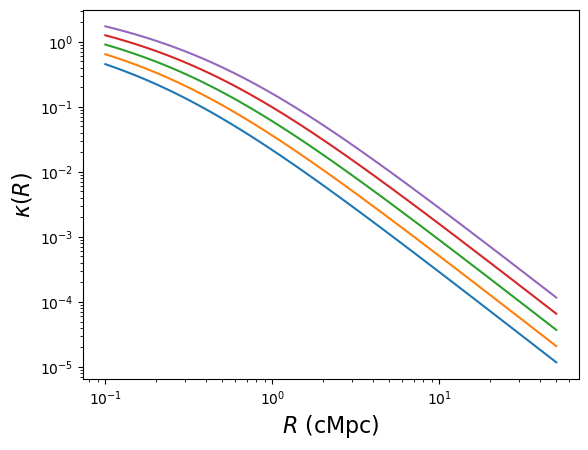

In [10]:
R = np.geomspace(0.1, 50.0, 100) # comoving Mpc 
zs = 1100
kappa_1h = nfw.convergence(R, zs)
plt.loglog(R, kappa_1h)
plt.xlabel('$R$ (cMpc)', fontsize=16)
plt.ylabel(r'$\kappa(R)$', fontsize=16);


Now for the 2-halo term. Let's start by setting the cosmology within `CCL`

In [11]:
h = 0.7
Om = 0.3
Ob = 0.045
As = 2.1e-9
ns = 0.96
cosmo = ccl.Cosmology(Omega_c=Om-Ob, Omega_b=Ob, h=h, A_s=As, n_s=ns)

Now we can calculate the linear matter power spectrum

CPU times: user 4.5 s, sys: 0 ns, total: 4.5 s
Wall time: 859 ms


Text(0, 0.5, '$P(k)$')

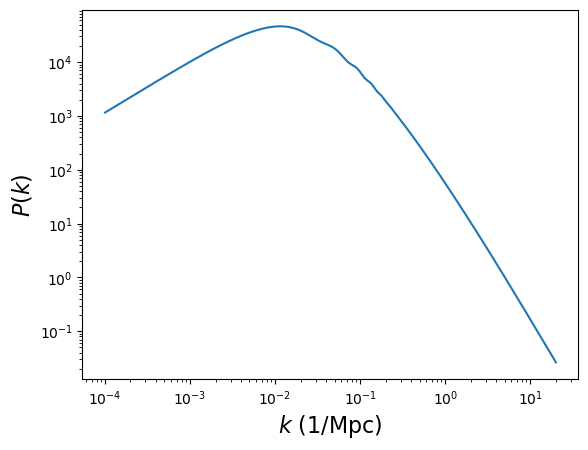

In [12]:
%%time

k = np.geomspace(1e-15, 1e15, 10000) # this wide range is needed for the Hankel transform                                                                 
kmin = 1e-4; kmax=20.0 # 1/Mpc; but only this k-range matters                                                                                             
sel = np.logical_and(k>kmin,k<kmax)                                                                                                                       
Pk = k*0 # the rest can be set to zero                                                                                                                                                  
Pk[sel] = ccl.linear_matter_power(cosmo, k[sel], 1/(1+z))

plt.loglog(k[sel],Pk[sel])
plt.xlabel('$k$ (1/Mpc)', fontsize=16)
plt.ylabel(r'$P(k)$', fontsize=16)


and multiply by a halo bias to get the galaxy-matter power spectrum.
$$
    P_\mathrm{gm}^\mathrm{2h}(k|m,z) = b(m,z)P_\mathrm{m}(k|z)
$$

 Doing this requires defining the mass in `CCL`:

In [13]:
%%time
mdef = ccl.halos.MassDef(delta, background)
bias = ccl.halos.HaloBiasTinker10(mass_def=mdef)
bh = bias(cosmo, m, 1/(1+nfw.z))
Pgm = bh[:,None] * Pk
Pgm.shape

CPU times: user 791 ms, sys: 0 ns, total: 791 ms
Wall time: 132 ms


(5, 10000)

We now convert this power spectrum into a correlation function

$$
\xi_\mathrm{gm}(r|m,z) = 
    \frac1{2\pi^2}\int_0^\infty \frac{\sin kr}{kr}k^2\,dk\, P_\mathrm{gm}^\mathrm{2h}
    $$

`profiley` has a helper function called `power2xi` (see import above) to convert to a correlation function. Be sure that the radii used cover a wide enough range to avoid problems when turning this into a surface density. (Credit goes to Andrej Dvornik for writing this function as part of the KiDS-GGL pipeline; used in `profiley` with permission.) Note that `power2xi` takes an `interp1d` object in natural-log space; running `power2xi` over multiple redshifts can only be accomplished by looping over it.

<timed exec>:4: RuntimeWarning: divide by zero encountered in log


CPU times: user 246 ms, sys: 219 μs, total: 246 ms
Wall time: 253 ms


Text(0, 0.5, '$\\xi(r)$')

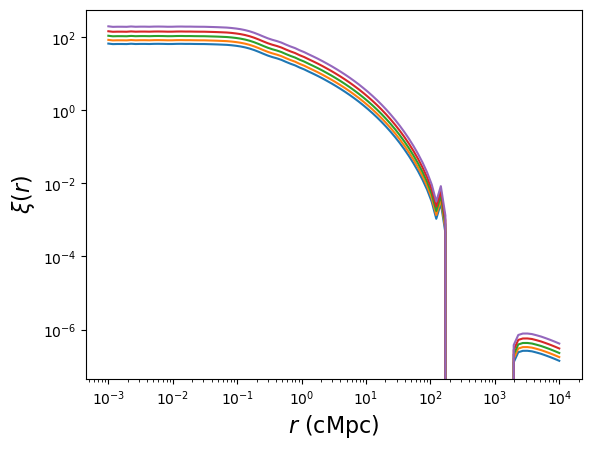

In [14]:
%%time
r_xi = np.geomspace(1e-3, 1e4, 100) # Mpc
xi = np.zeros((m.size,r_xi.size))
for i, Pgm_i in enumerate(Pgm):
    lnPgm_lnk = interp1d(np.log(k), np.log(Pgm_i))
    xi[i] = power2xi(lnPgm_lnk, r_xi)
xi.shape

[plt.loglog(r_xi,xi[i]) for i in range(xi.shape[0])]
plt.xlabel('$r$ (cMpc)', fontsize=16)
plt.ylabel(r'$\xi(r)$', fontsize=16)

We now come to the slow part: projecting the correlation function into a surface density. 

$$
\Sigma_\mathrm{2h}(R|m,z) = 2\bar\rho_\mathrm{m}R
    \int_0^1\frac{dx}{x^2\sqrt{1-x^2}}\,\xi_\mathrm{gm}(R/x|m,z)
    $$

where $\bar\rho_\mathrm{m}$ is the (time-independent) comoving mean matter density. Be sure to try this out before running in "production mode", including saving it to a file so you don't need to run this multiple times to get the same outcome. We will use the same distances we used for the 1-halo term to calculate the 2-halo term.

We calculate the background density at $z=0$ which is equal to the comoving matter density at all redshifts. Note that for the time being the output of `xi2sigma` has to be transposed to be consistent with the 1-halo calculations. 

In [15]:
rho_m = ccl.background.rho_x(cosmo, 1, 'matter')

In [16]:
%%time
sigma_2h = xi2sigma(R, r_xi, xi, rho_m).T
sigma_2h.shape

Internally rearranging input data...
Calculating 5 surface densities using 1 threads. This may take a while...
Calculated 5 surface densities in 0.13 min, for an average time of 1.59 sec per call.
CPU times: user 7.91 s, sys: 13.6 ms, total: 7.92 s
Wall time: 7.96 s


(100, 5)

Note that it took of order 10 seconds to calculate sigma 5 times, i.e., roughly two seconds per instance! For a full halo model fitting analysis - let alone an MCMC - where you might need to calculate this thousands of times, it can add up!

At any rate, we now have our two-halo surface density:

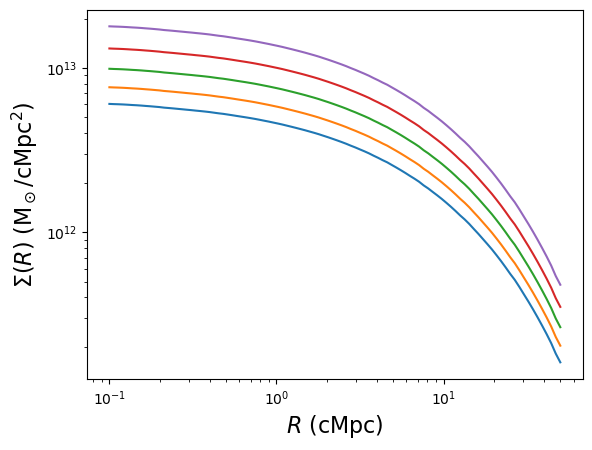

In [17]:
plt.loglog(R, sigma_2h)

plt.xlabel('$R$ (cMpc)', fontsize=16)
plt.ylabel(r'$\Sigma(R)$ (M$_\odot$/cMpc$^2$)', fontsize=16);

In order to turn this into a covergence we need to divide by the critical surface density (which is already in comoving coordinates since that's how ``nfw`` was defined).

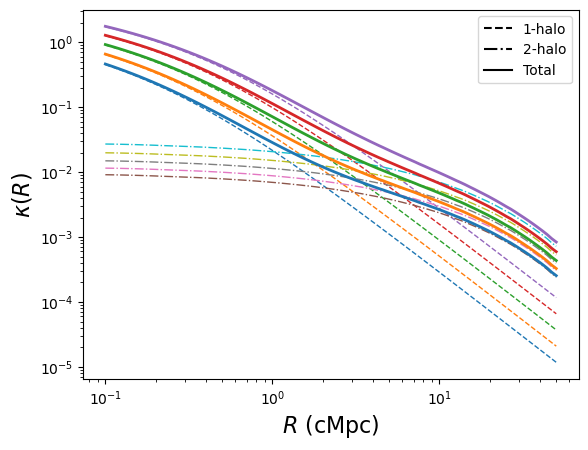

In [18]:
kappa_2h = sigma_2h / nfw.sigma_crit(zs)

plt.loglog(R, kappa_1h, '--', lw=1)
plt.plot(R, kappa_2h, '-.', lw=1)
plt.plot(R, kappa_1h+kappa_2h, '-', lw=2)
plt.plot([], [], 'k--', label='1-halo')
plt.plot([], [], 'k-.', label='2-halo')
plt.plot([], [], 'k-', label='Total')
plt.legend()
plt.xlabel('$R$ (cMpc)', fontsize=16)
plt.ylabel(r'$\kappa(R)$', fontsize=16);